### Dog Classification Model

The code below outlines the process in which we created a model to determine the dog breed from an image. 

In [1]:
#import libraries
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from glob import glob # helps read in pathnames

Using TensorFlow backend.


In [2]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names by grabbing the name of each breed for which we have an image folder
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog breeds.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d test dog images.'% len(test_files))
print('There are %d validation dog images.' % len(valid_files))

There are 133 total dog breeds.
There are 8351 total dog images.

There are 6680 training dog images.
There are 836 test dog images.
There are 835 validation dog images.


### Explore the data

1. Examine breakdown of images for each dog breed
2. Examine the height and width of each image 

In [51]:
df = []

def class_graph(loc):
    breedNames = []
    breedFiles = []
    dogDf = pd.DataFrame()

    for  folder in sorted(glob("dogImages/"+loc+"/*/")):
        breedNames.append(folder[19:-1])
        breedFiles.append(len(folder))    
    dogDf['Breed_Names'] = breedNames
    dogDf['Num_of_Files'] = breedFiles
    plt.figure(figsize=(20,5))
    plt.xticks(rotation=90)
    plt.bar(breedNames,breedFiles)
    plt.show()
    df.append(dogDf)
    dogDf.to_csv('exploration/'+loc+'.csv')
    return dogDf

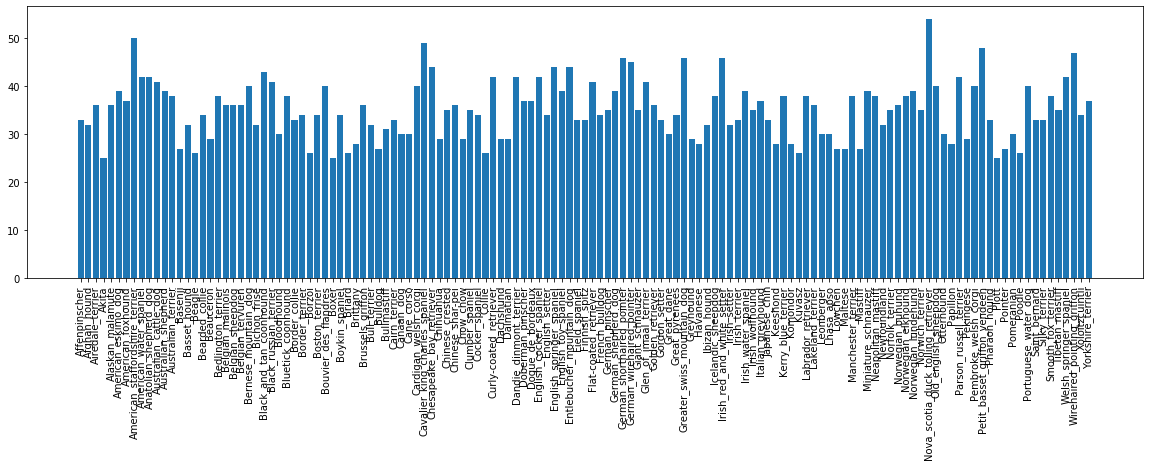

,Breed_Names,Num_of_Files
0,Affenpinscher,33
1,Afghan_hound,32
2,Airedale_terrier,36
3,Akita,25
4,Alaskan_malamute,36
...,...,...
128,Tibetan_mastiff,35
129,Welsh_springer_spaniel,42
130,Wirehaired_pointing_griffon,47
131,Xoloitzcuintli,34


In [52]:
class_graph('test')

Perform a closer look at count. May want to supplement these breeds with more images. 

In [5]:
breedDf = df[0]
breedDf2 = breedDf.sort_values(by=['Num_of_Files'])
breedDf2.head()

,Breed_Names,Num_of_Files
3,Akita,25
120,Plott,25
33,Boxer,25
94,Kuvasz,26
123,Poodle,26


The df shows us the number of test images for each class, which there isn't much variance between them.  This would indicate that we can use the accuracy metric since the classes are close to balanced.

In [6]:
import cv2  #use features within OpenCV

imgHeight=[]
imgWidth=[]
for i in range(0,len(train_files)):
    img = cv2.imread(train_files[i])
    height, width, channels = img.shape 
    imgHeight.append(height)
    imgWidth.append(width)

Text(0, 0.5, 'Image Width')

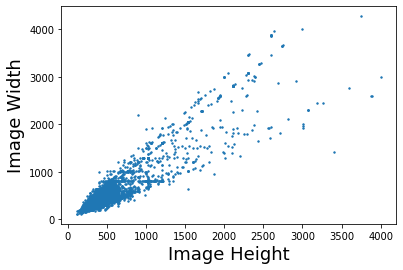

In [7]:
#create a scatterplot to look at the overall heigh/weight spread of the data. 
plt.scatter(imgHeight,imgWidth, s=2)
plt.xlabel('Image Height', fontsize=18)
plt.ylabel('Image Width', fontsize=18)

The scatterplot shows that most of the images are around 1000 x 1000 pixles.

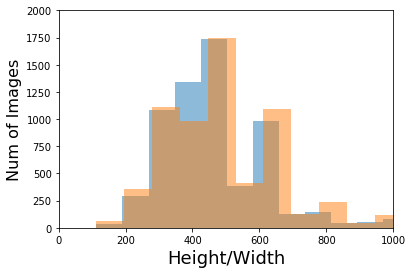

In [8]:
plt.hist(imgHeight,bins = 50, alpha=0.5)
plt.hist(imgWidth,bins = 50,alpha=0.5)
plt.axis([0,1000,0,2000])
plt.xlabel('Height/Width', fontsize=18)
plt.ylabel('Num of Images', fontsize=16)
plt.show()

# Preprocess the Data

Below are extensive notes about how the image must be shaped in order to used in the model. 

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [9]:
from keras.preprocessing import image  #allows Keras to view/process images                
from tqdm import tqdm  #logs the looping progress

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

## Use CNN to Classify Dog Breeds 

We used the bottleneck features from the Xception pre-trained model.  

In [10]:
# Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogXceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']

In [11]:
# Define the architecture.  There are 133 different breeds, which is used for the dense layer 
from keras.layers import GlobalAveragePooling2D  #add global average pooling 2D
from keras.layers import Dense  #add the dense layer
from keras.models import Sequential  #add the sequential function

Xception_model = Sequential()
Xception_model.add(GlobalAveragePooling2D(input_shape=(train_Xception.shape[1:])))
Xception_model.add(Dense(133, activation='softmax'))

Xception_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


##  Compile the Model

Here is an article about how to choose Last Layer activation and loss function [website](https://www.dlology.com/blog/how-to-choose-last-layer-activation-and-loss-function/).

In [12]:
# Compile the model.

Xception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

### Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [13]:
# Train the model
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

Xception_model.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - ETA: 15s - loss: 4.99 - ETA: 5s - loss: 4.9486 - ETA: 4s - loss: 4.799 - ETA: 4s - loss: 4.483 - ETA: 3s - loss: 4.275 - ETA: 3s - loss: 3.992 - ETA: 3s - loss: 3.777 - ETA: 3s - loss: 3.574 - ETA: 3s - loss: 3.377 - ETA: 3s - loss: 3.201 - ETA: 3s - loss: 3.048 - ETA: 3s - loss: 2.894 - ETA: 3s - loss: 2.748 - ETA: 3s - loss: 2.627 - ETA: 2s - loss: 2.523 - ETA: 2s - loss: 2.436 - ETA: 2s - loss: 2.351 - ETA: 2s - loss: 2.278 - ETA: 2s - loss: 2.210 - ETA: 2s - loss: 2.134 - ETA: 2s - loss: 2.079 - ETA: 2s - loss: 2.013 - ETA: 2s - loss: 1.958 - ETA: 2s - loss: 1.905 - ETA: 2s - loss: 1.854 - ETA: 2s - loss: 1.811 - ETA: 2s - loss: 1.773 - ETA: 2s - loss: 1.732 - ETA: 2s - loss: 1.696 - ETA: 2s - loss: 1.664 - ETA: 2s - loss: 1.627 - ETA: 2s - loss: 1.600 - ETA: 1s - loss: 1.578 - ETA: 1s - loss: 1.552 - ETA: 1s - loss: 1.526 - ETA: 1s - loss: 1.502 - ETA: 1s - loss: 1.474 - ETA: 1s 

6680/6680 [==============================] - ETA: 3s - loss: 0.399 - ETA: 3s - loss: 0.156 - ETA: 3s - loss: 0.279 - ETA: 3s - loss: 0.237 - ETA: 3s - loss: 0.224 - ETA: 3s - loss: 0.224 - ETA: 3s - loss: 0.202 - ETA: 3s - loss: 0.194 - ETA: 3s - loss: 0.211 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.218 - ETA: 3s - loss: 0.219 - ETA: 3s - loss: 0.208 - ETA: 3s - loss: 0.213 - ETA: 3s - loss: 0.217 - ETA: 2s - loss: 0.215 - ETA: 2s - loss: 0.212 - ETA: 2s - loss: 0.211 - ETA: 2s - loss: 0.213 - ETA: 2s - loss: 0.218 - ETA: 2s - loss: 0.225 - ETA: 2s - loss: 0.225 - ETA: 2s - loss: 0.226 - ETA: 2s - loss: 0.226 - ETA: 2s - loss: 0.229 - ETA: 2s - loss: 0.229 - ETA: 2s - loss: 0.239 - ETA: 2s - loss: 0.242 - ETA: 2s - loss: 0.239 - ETA: 2s - loss: 0.238 - ETA: 2s - loss: 0.235 - ETA: 2s - loss: 0.235 - ETA: 1s - loss: 0.237 - ETA: 1s - loss: 0.237 - ETA: 1s - loss: 0.236 - ETA: 1s - loss: 0.238 - ETA: 1s - loss: 0.237 - ETA: 1s - loss: 0.237 - ETA: 1s - loss: 0.236 - ETA: 1s - loss: 0.2

6680/6680 [==============================] - ETA: 3s - loss: 0.279 - ETA: 3s - loss: 0.167 - ETA: 3s - loss: 0.121 - ETA: 3s - loss: 0.135 - ETA: 3s - loss: 0.137 - ETA: 3s - loss: 0.123 - ETA: 3s - loss: 0.138 - ETA: 3s - loss: 0.168 - ETA: 3s - loss: 0.160 - ETA: 3s - loss: 0.152 - ETA: 2s - loss: 0.145 - ETA: 2s - loss: 0.155 - ETA: 2s - loss: 0.149 - ETA: 2s - loss: 0.141 - ETA: 2s - loss: 0.150 - ETA: 2s - loss: 0.155 - ETA: 2s - loss: 0.160 - ETA: 2s - loss: 0.160 - ETA: 2s - loss: 0.156 - ETA: 2s - loss: 0.155 - ETA: 2s - loss: 0.152 - ETA: 2s - loss: 0.149 - ETA: 2s - loss: 0.148 - ETA: 2s - loss: 0.147 - ETA: 2s - loss: 0.145 - ETA: 2s - loss: 0.148 - ETA: 2s - loss: 0.148 - ETA: 2s - loss: 0.147 - ETA: 2s - loss: 0.145 - ETA: 2s - loss: 0.146 - ETA: 1s - loss: 0.144 - ETA: 1s - loss: 0.146 - ETA: 1s - loss: 0.145 - ETA: 1s - loss: 0.144 - ETA: 1s - loss: 0.142 - ETA: 1s - loss: 0.141 - ETA: 1s - loss: 0.144 - ETA: 1s - loss: 0.145 - ETA: 1s - loss: 0.143 - ETA: 1s - loss: 0.1

6680/6680 [==============================] - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.028 - ETA: 3s - loss: 0.039 - ETA: 3s - loss: 0.042 - ETA: 3s - loss: 0.055 - ETA: 3s - loss: 0.061 - ETA: 3s - loss: 0.062 - ETA: 3s - loss: 0.075 - ETA: 3s - loss: 0.086 - ETA: 3s - loss: 0.088 - ETA: 2s - loss: 0.093 - ETA: 2s - loss: 0.090 - ETA: 2s - loss: 0.086 - ETA: 2s - loss: 0.087 - ETA: 2s - loss: 0.086 - ETA: 2s - loss: 0.091 - ETA: 2s - loss: 0.087 - ETA: 2s - loss: 0.093 - ETA: 2s - loss: 0.093 - ETA: 2s - loss: 0.090 - ETA: 2s - loss: 0.087 - ETA: 2s - loss: 0.096 - ETA: 2s - loss: 0.096 - ETA: 2s - loss: 0.096 - ETA: 2s - loss: 0.096 - ETA: 2s - loss: 0.101 - ETA: 2s - loss: 0.101 - ETA: 2s - loss: 0.099 - ETA: 2s - loss: 0.100 - ETA: 2s - loss: 0.100 - ETA: 1s - loss: 0.098 - ETA: 1s - loss: 0.098 - ETA: 1s - loss: 0.097 - ETA: 1s - loss: 0.097 - ETA: 1s - loss: 0.102 - ETA: 1s - loss: 0.105 - ETA: 1s - loss: 0.103 - ETA: 1s - loss: 0.102 - ETA: 1s - loss: 0.101 - ETA: 1s - loss: 0.1

6680/6680 [==============================] - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.038 - ETA: 3s - loss: 0.059 - ETA: 3s - loss: 0.132 - ETA: 3s - loss: 0.146 - ETA: 3s - loss: 0.138 - ETA: 3s - loss: 0.134 - ETA: 3s - loss: 0.138 - ETA: 3s - loss: 0.126 - ETA: 3s - loss: 0.132 - ETA: 3s - loss: 0.121 - ETA: 3s - loss: 0.112 - ETA: 2s - loss: 0.106 - ETA: 2s - loss: 0.102 - ETA: 2s - loss: 0.100 - ETA: 2s - loss: 0.096 - ETA: 2s - loss: 0.091 - ETA: 2s - loss: 0.087 - ETA: 2s - loss: 0.088 - ETA: 2s - loss: 0.088 - ETA: 2s - loss: 0.088 - ETA: 2s - loss: 0.090 - ETA: 2s - loss: 0.089 - ETA: 2s - loss: 0.087 - ETA: 2s - loss: 0.088 - ETA: 2s - loss: 0.088 - ETA: 2s - loss: 0.089 - ETA: 2s - loss: 0.088 - ETA: 2s - loss: 0.094 - ETA: 2s - loss: 0.095 - ETA: 2s - loss: 0.093 - ETA: 1s - loss: 0.091 - ETA: 1s - loss: 0.091 - ETA: 1s - loss: 0.091 - ETA: 1s - loss: 0.091 - ETA: 1s - loss: 0.091 - ETA: 1s - loss: 0.092 - ETA: 1s - loss: 0.091 - ETA: 1s - loss: 0.090 - ETA: 1s - loss: 0.0

### Load the Model with the Best Validation Loss

In [15]:
# Load the model weights with the best validation loss.

Xception_model.load_weights('saved_models/weights.best.Xception.hdf5')


### Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [16]:
# Calculate classification accuracy on the test dataset.

# get index of predicted dog breed for each image in test set
Xception_predictions = [np.argmax(Xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 83.2536%


### Predict Dog Breed with the Model

This function will that take the img_path and return the dog breed that the model predicts.

In this function we will:
1. Extract the bottleneck features for Xception model
2. Supply the bottleneck features as input to the model to return the predicted vector.  
    a. Note: that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array to return the corresponding breed.

In [28]:
# A function that takes a path to an image as input and returns the dog breed that is predicted by the model.
from extract_bottleneck_features import *

def Xception_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    print(bottleneck_feature.shape)
    # obtain predicted vector
    predicted_vector = Xception_model.predict(bottleneck_feature)
    print(predicted_vector.shape)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [29]:
import sklearn  #allows us to access the classsication report feature
from sklearn.metrics import classification_report   #allows us to see the accuracy of the model against each classification

In [30]:
#create the classification report, which includes the precision, recall, f1-score and support values
Y_test = np.argmax(test_targets, axis=1) 
y_pred = Xception_model.predict_classes(test_Xception)
report = classification_report(Y_test, y_pred, output_dict=True)

C:\Users\jseymour\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [31]:
#move the classification report into a df so we can export to a csv to load to postgres Db dog attribure table
recallDf = pd.DataFrame(report).transpose()  
recallDf.to_csv('exploration/recallDf.csv')  

In [32]:
#save off the keras model to be called from Flask
Xception_model.save('saved_models/dogClassification_test.h5')

In [33]:
import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [41]:
# Recreate the exact same model purely from the file
classifier = keras.models.load_model('saved_models/dogClassification.h5')

## Predict Top 5

The predict_vector estimates the probability of each dog breed from the image. We must associate the predict_vector with dog_names to map the probability to a dog a breed. Below we grab the position of five highest probabilities and associate that with the dog breed. We also display the probability of the top five. 

In [42]:
from keras.preprocessing import image
import numpy as np

img_path='C:/Users/jseymour/Desktop/Pics/Golden_Retriever.jpg'

# recreating the path_to_tensor function

test_image = image.load_img(img_path, target_size=(224,224))

test_image = image.img_to_array(test_image)

test_image = np.expand_dims(test_image, axis=0)
test_image = extract_Xception(test_image)
predicted_vector = Xception_model.predict(test_image)
result = dog_names[np.argmax(predicted_vector)]
print(result)

Golden_retriever


In [43]:
import heapq

top5=heapq.nlargest(5, range(len(predicted_vector[0])), key=predicted_vector[0].__getitem__)
print(top5)

[75, 111, 95, 61, 46]


In [44]:
result1=dog_names[top5[0]]
result2=dog_names[top5[1]]
result3=dog_names[top5[2]]
result4=dog_names[top5[3]]
result5=dog_names[top5[4]]
print(result1)
print(result2)
print(result3)
print(result4)
print(result5)

Golden_retriever
Nova_scotia_duck_tolling_retriever
Labrador_retriever
English_setter
Chesapeake_bay_retriever


In [45]:
percent1=predicted_vector[0][top5[0]]*100
percent2=predicted_vector[0][top5[1]]*100
percent3=predicted_vector[0][top5[2]]*100
percent4=predicted_vector[0][top5[3]]*100
percent5=predicted_vector[0][top5[4]]*100
print(percent1)
print(percent2)
print(percent3)
print(percent4)
print(percent5)

98.44692349433899
0.5775189027190208
0.574015686288476
0.1949748257175088
0.1144609646871686
